In [49]:
import re
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

## Objectives

The objective of this study is to predict the type of response from the other features of the complaint.

Null Hypothesis 1: Response type cannot be predicted from the Compliant

Alternative Hypothesis: Complaint variables can be used to predict the type of response.




In [50]:
df = pd.read_csv(r'C:\Users\Shweta\Documents\SQL Training\Google course\Springboard\Capstone Three\CFPB_six_months_data.csv')

In [51]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,None,Other,Web,03/12/23,Closed with non-monetary relief,Yes,NaN,6679469
1,02/02/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,None,"EQUIFAX, INC.",NY,13787,None,Consent not provided,Web,02/02/23,Closed with explanation,Yes,NaN,6531965
2,02/18/23,Credit card or prepaid card,Government benefit card,Trouble using the card,Trouble getting information about the card,The MoneyNetwork website and phone customer se...,None,FISERV INC.,WA,98223,Servicemember,Consent provided,Web,02/18/23,Closed with explanation,Yes,NaN,6588274
3,02/28/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,"EQUIFAX, INC.",OH,44313,None,Other,Web,02/28/23,Closed with explanation,Yes,NaN,6621909
4,02/18/23,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Card opened as result of identity theft or fraud,XX/XX/XXXX : I got an email that I opened a XX...,None,CAPITAL ONE FINANCIAL CORPORATION,CA,90815,None,Consent provided,Web,02/18/23,Closed with non-monetary relief,Yes,NaN,6588699


In [52]:
df['Sub-product'].nunique()

48

In [53]:
df['State'].nunique()

60

In [54]:
df['Company'].nunique()

2558

In [55]:
df.Company.value_counts().head(20)

TRANSUNION INTERMEDIATE HOLDINGS, INC.    144038
EQUIFAX, INC.                             139776
Experian Information Solutions Inc.       131083
WELLS FARGO & COMPANY                      13002
CAPITAL ONE FINANCIAL CORPORATION           7561
BANK OF AMERICA, NATIONAL ASSOCIATION       6524
JPMORGAN CHASE & CO.                        6158
CITIBANK, N.A.                              4405
Bread Financial Holdings, Inc.              3358
SYNCHRONY FINANCIAL                         3116
DISCOVER BANK                               2131
AMERICAN EXPRESS COMPANY                    2042
Resurgent Capital Services L.P.             1962
NAVY FEDERAL CREDIT UNION                   1948
U.S. BANCORP                                1808
Paypal Holdings, Inc                        1795
LEXISNEXIS                                  1778
PORTFOLIO RECOVERY ASSOCIATES INC           1732
ALLY FINANCIAL INC.                         1731
TRUIST FINANCIAL CORPORATION                1608
Name: Company, dtype

In [56]:
df['Issue'].nunique()

78

In [57]:
df['Sub-issue'].nunique()

163

In [58]:
df['Company public response'].nunique()

11

In [59]:
df['Tags'].nunique()

4

In [60]:
df['Company'].nunique()

2558

In [76]:
df['Submitted via'].nunique()

6

In [78]:
df['Submitted via'].value_counts(dropna=False)

Web             538332
Phone            10895
Referral          3209
Postal mail       2672
Web Referral       419
Email                1
Name: Submitted via, dtype: int64

In [61]:
df['Consumer consent provided?'].nunique()

5

In [62]:
df['Consumer consent provided?'].value_counts(dropna=False)

Consent not provided    207958
Consent provided        162127
None                    137634
Other                    29791
NaN                      16777
Consent withdrawn         1241
Name: Consumer consent provided?, dtype: int64

The columns - Company, Issue, Sub-Issue, State, Zipcode, Sub-product have high cardinality - high number of unique values. This could lead to the curse of dimensionality if we were to apply one-hot encoding. To minimise this risk, we could either delete these columns or retain them by reducing the dimensions. 

The column Consumer consent provided is not related to the study. This column just records whether the customer has provided consent to display their narrative publicly. The column also has missing values and we are not sure what they may lead to. Hence this column could be safely eliminated or the missing values could be just replaced with missing. 


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555528 entries, 0 to 555527
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date received                 555528 non-null  object 
 1   Product                       555528 non-null  object 
 2   Sub-product                   555528 non-null  object 
 3   Issue                         555528 non-null  object 
 4   Sub-issue                     555528 non-null  object 
 5   Consumer complaint narrative  162085 non-null  object 
 6   Company public response       555528 non-null  object 
 7   Company                       555528 non-null  object 
 8   State                         555528 non-null  object 
 9   ZIP code                      555528 non-null  object 
 10  Tags                          555528 non-null  object 
 11  Consumer consent provided?    538751 non-null  object 
 12  Submitted via                 555528 non-nul

### Making a predictor variable y

In [79]:
y = df['Company response to consumer']

In [80]:
#Check the type of our new variable. 
type(y)

pandas.core.series.Series

### Train/Test Split

In [81]:
df.shape

(555528, 18)

In [82]:
len(df) * .7, len(df) * .3

(388869.6, 166658.4)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Company response to consumer'), 
                                                    df['Company response to consumer'], test_size=0.3, 
                                                    random_state=47)

In [84]:
X_train.shape, X_test.shape

((388869, 17), (166659, 17))

In [85]:
y_train.shape, y_test.shape

((388869,), (166659,))

Now, we do one hot encoding, repalcing null values if any, deleting columns and text processing separately on train and test data.

### Deleting columns in X Train

Since we are not in a time series analysis, we could certainly drop the dates as the study relates more to how the reponse and time are related. Similarly since none of the consumers have disputed and we have only null values in the Consumer disputed column, we may as well delete it, so that it does not introduce bias. 

We would also delete a few columns with high cardinality and less significant to the study. For instance, Zipcodes have no role if we are considering states. Similarly, we would delete Sub-Issue and Company columns for this study.

In [87]:
#Setting column 'Complaint ID' as index 

X_train.set_index('Complaint ID', inplace=True)
X_test.set_index('Complaint ID', inplace=True)

In [88]:
#deleting the columns in X_Train
X_train.drop(['Date received','Consumer complaint narrative','Date sent to company','Sub-issue','Company','ZIP code', 'Consumer disputed?','Date sent to company'], axis=1, inplace =True)


In [89]:
X_test.drop(['Date received','Consumer complaint narrative','Date sent to company','Sub-issue','Company','ZIP code', 'Consumer disputed?','Date sent to company'], axis=1, inplace =True)


In [90]:
X_train.shape, X_test.shape

((388869, 9), (166659, 9))

In [91]:
X_train.head()

,Product,Sub-product,Issue,Company public response,State,Tags,Consumer consent provided?,Submitted via,Timely response?
Complaint ID,,,,,,,,,
6813626,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,None,OR,None,None,Web,Yes
6498004,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,None,CA,None,Consent provided,Web,Yes
6798153,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a credit reporting company's inve...,Company has responded to the consumer and the ...,TX,None,Consent provided,Web,Yes
6624844,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Company has responded to the consumer and the ...,FL,None,Consent provided,Web,Yes
6487844,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,None,AR,None,Consent not provided,Web,Yes


In [92]:
# checking for null values in each column. 
X_train.isnull().sum().sort_values()

Product                           0
Sub-product                       0
Issue                             0
Company public response           0
State                             0
Tags                              0
Submitted via                     0
Timely response?                  0
Consumer consent provided?    11749
dtype: int64

In [94]:
# impute missing values of consumer consent provided in both X_train and X_test
X_train.fillna('Missing', inplace =True)
X_test.fillna('Missing', inplace = True)

In [95]:
# checking for null values in each column. 
X_train.isnull().sum().sort_values()

Product                       0
Sub-product                   0
Issue                         0
Company public response       0
State                         0
Tags                          0
Consumer consent provided?    0
Submitted via                 0
Timely response?              0
dtype: int64

We could also analyse the text to see the most frequent words. This could be a part of future study to analyse of sentiments could affect the type of response. 

## Text Analysis 

#### Step 1:Transform all customer narratives into lower case and create a new column new_narratives

In [5]:

df['new_narratives'] = df['Consumer complaint narrative'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
df['new_narratives'].head(10)

0                                                  nan
1                                                  nan
2    the moneynetwork website and phone customer se...
3                                                  nan
4    xx/xx/xxxx : i got an email that i opened a xx...
5    my name is xxxx xxxx this complaint is not mad...
6    this is my numerous request that i have been a...
7    i have contacted the company several times on ...
8                                                  nan
9    i paid off my car note weeks ago, but i can't ...
Name: new_narratives, dtype: object

#### Step 2:Remove Punctuation

In [6]:
df['new_narratives'] = df['new_narratives'].str.replace('[^\w\s]','')
df['new_narratives'].head(10)

C:\Users\Shweta\AppData\Local\Temp\ipykernel_19288\1753682588.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['new_narratives'] = df['new_narratives'].str.replace('[^\w\s]','')


0                                                  nan
1                                                  nan
2    the moneynetwork website and phone customer se...
3                                                  nan
4    xxxxxxxx  i got an email that i opened a xxxx ...
5    my name is xxxx xxxx this complaint is not mad...
6    this is my numerous request that i have been a...
7    i have contacted the company several times on ...
8                                                  nan
9    i paid off my car note weeks ago but i cant se...
Name: new_narratives, dtype: object

#### Step 3: Remove Stopwords

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop = stopwords.words('english')
df['new_narratives'] = df['new_narratives'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
df.head(20)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,new_narratives
0,03/12/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,None,Other,Web,03/12/23,Closed with non-monetary relief,Yes,NaN,6679469,nan
1,02/02/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,None,"EQUIFAX, INC.",NY,13787,None,Consent not provided,Web,02/02/23,Closed with explanation,Yes,NaN,6531965,nan
2,02/18/23,Credit card or prepaid card,Government benefit card,Trouble using the card,Trouble getting information about the card,The MoneyNetwork website and phone customer se...,None,FISERV INC.,WA,98223,Servicemember,Consent provided,Web,02/18/23,Closed with explanation,Yes,NaN,6588274,moneynetwork website phone customer service li...
3,02/28/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,"EQUIFAX, INC.",OH,44313,None,Other,Web,02/28/23,Closed with explanation,Yes,NaN,6621909,nan
4,02/18/23,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Card opened as result of identity theft or fraud,XX/XX/XXXX : I got an email that I opened a XX...,None,CAPITAL ONE FINANCIAL CORPORATION,CA,90815,None,Consent provided,Web,02/18/23,Closed with non-monetary relief,Yes,NaN,6588699,xxxxxxxx got email opened xxxx credit card wou...
5,03/21/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,My name is XXXX XXXX this complaint is not mad...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,91739,None,Consent provided,Web,03/21/23,Closed with non-monetary relief,Yes,NaN,6724156,name xxxx xxxx complaint made error neither ma...
6,02/02/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my NUMEROUS request that I have been a...,None,"EQUIFAX, INC.",CA,93637,None,Consent provided,Web,02/02/23,Closed with explanation,Yes,NaN,6520651,numerous request victim identity theft one see...
7,02/18/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I have contacted the company several times on ...,None,"Avant Holding Company, Inc.",FL,33319,None,Consent provided,Web,02/18/23,Closed with explanation,Yes,NaN,6589840,contacted company several times numerous occas...
8,05/10/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,None,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,762XX,None,Other,Web,05/10/23,In progress,Yes,NaN,6956364,nan
9,04/06/23,Vehicle loan or lease,Loan,Problems at the end of the loan or lease,Unable to receive car title or other problem a...,"I paid off my car note weeks ago, but I can't ...",Company has responded to the consumer and the ...,HYUNDAI CAPITAL AMERICA,MI,48214,None,Consent provided,Web,05/09/23,Closed with explanation,Yes,NaN,6806510,paid car note weeks ago cant sell kia finance ...


#### Step 4: Spelling Corrections

In [10]:
#from textblob import TextBlob
#df['new_narratives'] = df['new_narratives'].apply(lambda x: str(TextBlob(x).correct()))
#df.head(10)

#### Step 5: Tokenization and Lemmatization

In [9]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df['lemmatized_tokens'] = df['new_narratives'].apply(lemmatize_text)
df.head(10)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,new_narratives,lemmatized_tokens
0,03/12/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,None,Other,Web,03/12/23,Closed with non-monetary relief,Yes,NaN,6679469,nan,[nan]
1,02/02/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,None,"EQUIFAX, INC.",NY,13787,None,Consent not provided,Web,02/02/23,Closed with explanation,Yes,NaN,6531965,nan,[nan]
2,02/18/23,Credit card or prepaid card,Government benefit card,Trouble using the card,Trouble getting information about the card,The MoneyNetwork website and phone customer se...,None,FISERV INC.,WA,98223,Servicemember,Consent provided,Web,02/18/23,Closed with explanation,Yes,NaN,6588274,moneynetwork website phone customer service li...,"[moneynetwork, website, phone, customer, servi..."
3,02/28/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,"EQUIFAX, INC.",OH,44313,None,Other,Web,02/28/23,Closed with explanation,Yes,NaN,6621909,nan,[nan]
4,02/18/23,Credit card or prepaid card,General-purpose credit card or charge card,Getting a credit card,Card opened as result of identity theft or fraud,XX/XX/XXXX : I got an email that I opened a XX...,None,CAPITAL ONE FINANCIAL CORPORATION,CA,90815,None,Consent provided,Web,02/18/23,Closed with non-monetary relief,Yes,NaN,6588699,xxxxxxxx got email opened xxxx credit card wou...,"[xxxxxxxx, got, email, opened, xxxx, credit, c..."
5,03/21/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,My name is XXXX XXXX this complaint is not mad...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,91739,None,Consent provided,Web,03/21/23,Closed with non-monetary relief,Yes,NaN,6724156,name xxxx xxxx complaint made error neither ma...,"[name, xxxx, xxxx, complaint, made, error, nei..."
6,02/02/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my NUMEROUS request that I have been a...,None,"EQUIFAX, INC.",CA,93637,None,Consent provided,Web,02/02/23,Closed with explanation,Yes,NaN,6520651,numerous request victim identity theft one see...,"[numerous, request, victim, identity, theft, o..."
7,02/18/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I have contacted the company several times on ...,None,"Avant Holding Company, Inc.",FL,33319,None,Consent provided,Web,02/18/23,Closed with explanation,Yes,NaN,6589840,contacted company several times numerous occas...,"[contacted, company, several, time, numerous, ..."
8,05/10/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,None,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,762XX,None,Other,Web,05/10/23,In progress,Yes,NaN,6956364,nan,[nan]
9,04/06/23,Vehicle loan or lease,Loan,Problems at the end of the loan or lease,Unable to receive car title or other problem a...,"I paid off my car note weeks ago, but I can't ...",Company has responded to the consumer and the ...,HYUNDAI CAPITAL AMERICA,MI,48214,None,Consent provided,Web,05/09/23,Closed with explanation,Yes,NaN,6806510,paid car note weeks ago cant sell kia finance ...,

### Text Exploration

#### 1. Visualizing the most frequent words:

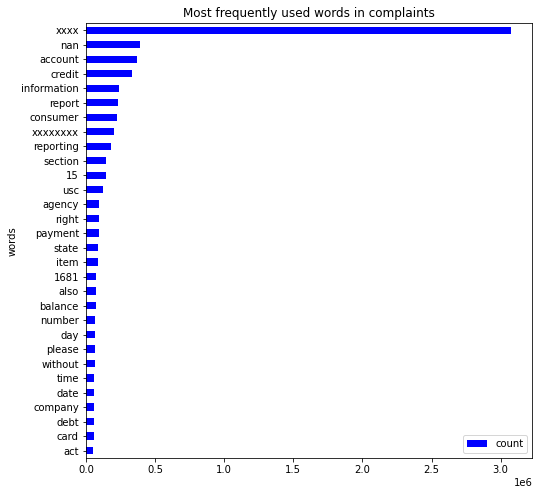

In [10]:
import itertools
import collections

lemmatized_tokens = list(df['lemmatized_tokens'])
token_list = list(itertools.chain(*lemmatized_tokens))

counts_no=collections.Counter(token_list)
clean_narratives = pd.DataFrame(counts_no.most_common(30), columns = ['words', 'count'])
                               
fig, ax = plt.subplots(figsize= (8, 8))
clean_narratives.sort_values(by = 'count').plot.barh(x = 'words', y= 'count', ax=ax, color = 'blue')
ax.set_title('Most frequently used words in complaints')
plt.show()
    

This is a good start and can be used to braoden the scope of this study. For now we go back to our split train and test sets.

### Dummy Encoding

Since our dataset is categorical, we would apply one-hot encoding to convert it to numerical.

In [97]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(X_train)
X_train= enc.transform(X_train)

X_test= enc.transform(X_test)

In [98]:
X_train.shape

(388869, 223)

In [99]:
X_test.shape

(166659, 223)

We have the same number of features in X_train and X_test. The data is now ready for modeling

### Modeling

#### Logistic Regression: 

In [110]:
from sklearn.linear_model import LogisticRegression
#Make an instance of the model(parameters set to default)
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter = 500)
#fit the model
logisticRegr.fit(X_train, y_train)
# make predictions
predictions = logisticRegr.predict(X_test)
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)


C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7836060458781104


In [111]:
# confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[54677    83 22187  5641    59]
 [ 2226    72    65    38     1]
 [ 3615     8 39998   369     0]
 [ 1674     0     0 35760     0]
 [   98     0     0     0    88]]


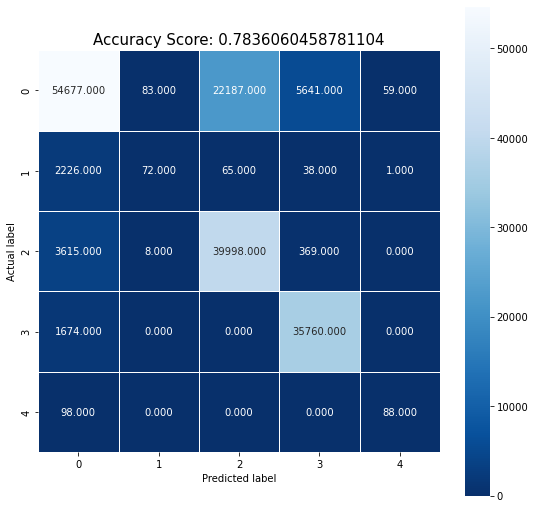

In [112]:
#Using seaborn to display the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [114]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

                                 precision    recall  f1-score   support

        Closed with explanation       0.88      0.66      0.75     82647
    Closed with monetary relief       0.44      0.03      0.06      2402
Closed with non-monetary relief       0.64      0.91      0.75     43990
                    In progress       0.86      0.96      0.90     37434
              Untimely response       0.59      0.47      0.53       186

                       accuracy                           0.78    166659
                      macro avg       0.68      0.61      0.60    166659
                   weighted avg       0.80      0.78      0.78    166659



In [154]:
#Cross Validation using Gridsearch
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'C': [0.001, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_parameters, cv=10, scoring="accuracy")
clf.fit(X_train, y_train)
print(clf.best_params_)

print(clf.best_score_)

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

{'C': 0.001}
0.7831171894560287


C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision Tree

In [117]:
from sklearn.tree import DecisionTreeClassifier
#Creating Instance
classifier_tree = DecisionTreeClassifier()
# Fit & Predict
y_predict = classifier_tree.fit(X_train, y_train).predict(X_test)
# Use score method to get accuracy of model
score = classifier_tree.score(X_test, y_test)
print(score)


0.779537858741502


In [118]:
#Confusion Matrix and Classification report
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

                                 precision    recall  f1-score   support

        Closed with explanation       0.87      0.66      0.75     82647
    Closed with monetary relief       0.25      0.10      0.15      2402
Closed with non-monetary relief       0.64      0.89      0.75     43990
                    In progress       0.85      0.95      0.90     37434
              Untimely response       0.51      0.46      0.48       186

                       accuracy                           0.78    166659
                      macro avg       0.62      0.61      0.61    166659
                   weighted avg       0.80      0.78      0.78    166659

[[54804   648 21455  5661    79]
 [ 2000   248    85    68     1]
 [ 4357    61 39205   366     1]
 [ 1762    48    48 35575     1]
 [   99     0     1     1    85]]


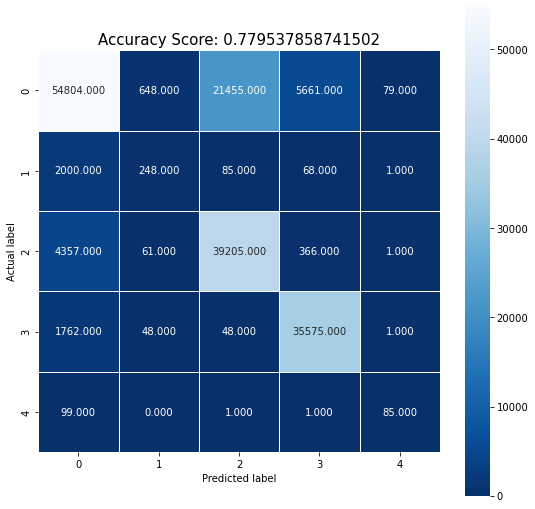

In [119]:
#Using seaborn to display the confusion matrix
cm=confusion_matrix(y_test, y_predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [120]:
#Hyper parameter tuning using Grid search
params =  {
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [1, 2, 3, 4, 5]
}
grid = GridSearchCV(estimator=classifier_tree,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)
grid.fit(X_train,y_train)
grid.best_score_, grid.best_params_

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=1, min_samples_lea

[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.8s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=4; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.9s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=2; total time=   0.8s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.7s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=gini, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.8s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   1.0s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.2s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.2s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.1s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.2s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=2; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=gini, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.8s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.8s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   1.1s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.1s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=4, min_samples_split=4; total time=   1.0s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   1.6s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   1.4s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   1.2s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.4s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=3; total time=   1.2s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=4; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=4; total time=   1.3s
[CV] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=4; total time=   1.4s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   1.5s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.7s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.6s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.7s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5; total time=   1.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=3, min_samples_split=1; total time=   0.7s
[CV] END criterion=g

[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=3; total time=   1.7s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=3; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=3; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4; total time=   1.6s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4; total time=   1.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4; total time=   1.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4; total time=   1.4s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4; total time=   1.5s
[CV] END criterion=g

[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=1, min_samples_split=2; total tim

[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.9s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.9s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=2, min_samples_split=5; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=3, min_samples_split=1; total tim

[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.7s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=4; total time=   0.8s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=4; total time=   0.7s
[CV] END criterion=entropy, max_depth=1, min_samples_leaf=4, min_samples_split=4; total tim

[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.8s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=2; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=1, min_samples_split=2; total tim

[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=4; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=2, min_samples_split=5; total tim

[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=2; total time=   1.1s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.0s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   1.2s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total time=   0.9s
[CV] END criterion=entropy, max_depth=2, min_samples_leaf=4, min_samples_split=3; total tim

[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=1; total time=   0.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=1, min_samples_split=2; total tim

[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.3s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.2s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.5s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   2.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   2.0s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=4; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=5; total time=   1.7s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=5; total tim

[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=2; total time=   1.7s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=3; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=3; total tim

[CV] END criterion=entropy, max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   1.6s
[CV] END criterion=entropy, max_depth=3, min_samples_leaf=5, min_samples_split=5; total time=   1.6s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.8s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   1.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.8s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total time=   0.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=1, min_samples_split=1; total tim

[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=3; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   2.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=2, min_samples_split=4; total tim

[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2; total time=   1.8s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=3; total tim

[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   2.2s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   1.9s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   2.0s
[CV] END criterion=entropy, max_depth=4, min_samples_leaf=5, min_samples_split=5; total time=   1.9s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=1; total time=   0.9s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=1; total time=   0.9s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=1; total tim

[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=3; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=3; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=3; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=3; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=3; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   1.8s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=4; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=4; total tim

[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=1; total time=   0.7s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   1.8s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   1.7s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   1.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total tim

[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=4; total time=   1.4s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.4s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.4s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.4s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.4s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total time=   1.4s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=5; total tim

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a floa

(0.7843515387614284,
 {'criterion': 'gini',
  'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 3})

#### Decision Tree-II:

In [138]:
#Using the best params of Decision tree to create the new model
#Creating Instance
classifier_tree_best = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=3)
# Fit & Predict
y_predict = classifier_tree_best.fit(X_train, y_train).predict(X_test)
# Use score method to get accuracy of model
score = classifier_tree_best.score(X_test, y_test)
print(score)

0.7847700994245735


In [139]:
#Confusion Matrix and Classification report
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

        Closed with explanation       0.86      0.68      0.76     82647
    Closed with monetary relief       0.00      0.00      0.00      2402
Closed with non-monetary relief       0.65      0.89      0.75     43990
                    In progress       0.87      0.93      0.90     37434
              Untimely response       0.62      0.30      0.40       186

                       accuracy                           0.78    166659
                      macro avg       0.60      0.56      0.56    166659
                   weighted avg       0.79      0.78      0.78    166659

[[56450     0 21195  4968    34]
 [ 2347     0    46     9     0]
 [ 4344     0 39329   317     0]
 [ 2479     0     0 34955     0]
 [  123     0     0     8    55]]


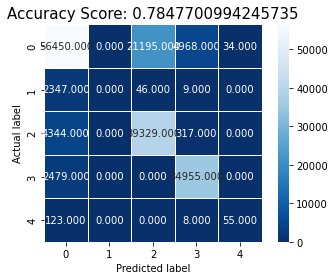

In [155]:
# Display a normalized confusion matrix heatmap with class labels
cm = confusion_matrix(y_test, y_predict)
# Normalise
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#labels = classifier_tree_best.classes_
#conf_df = pd.DataFrame(cmn, columns=labels, index=labels)
#conf_df.index.name = 'True labels'
#conf_df
#plt.figure(figsize=(10,10))
#sns.heatmap(conf_df, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
#all_sample_title = 'Accuracy Score: {0}'.format(score)
#plt.title(all_sample_title, size = 15);
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.show(block=False)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Random Forest Model

In [123]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=47, n_estimators=100,)
RF.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = RF.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))



ACCURACY OF THE MODEL:  0.7824299917796219


In [124]:
#Confusion Matrix and Classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                                 precision    recall  f1-score   support

        Closed with explanation       0.87      0.67      0.76     82647
    Closed with monetary relief       0.30      0.10      0.15      2402
Closed with non-monetary relief       0.65      0.89      0.75     43990
                    In progress       0.85      0.95      0.90     37434
              Untimely response       0.60      0.40      0.48       186

                       accuracy                           0.78    166659
                      macro avg       0.66      0.60      0.61    166659
                   weighted avg       0.80      0.78      0.78    166659

[[55156   465 21313  5665    48]
 [ 2030   232    76    63     1]
 [ 4298    53 39276   363     0]
 [ 1725    23    26 35660     0]
 [  111     0     0     0    75]]


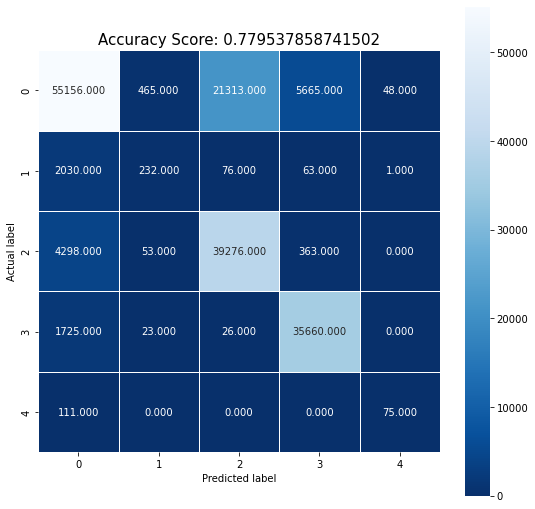

In [125]:
#Using seaborn to display the confusion matrix
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

#### Random Forest -II:

In [134]:

rfc1=RandomForestClassifier(random_state=47, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')


In [135]:
rfc1.fit(X_train, y_train)


RandomForestClassifier(max_depth=8, n_estimators=200, random_state=47)

In [136]:
pred=rfc1.predict(X_test)

In [137]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.7747016362752687


In [153]:
#Confusion Matrix and Classification report
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shweta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

        Closed with explanation       0.83      0.70      0.76     82647
    Closed with monetary relief       0.00      0.00      0.00      2402
Closed with non-monetary relief       0.65      0.90      0.75     43990
                    In progress       0.89      0.85      0.87     37434
              Untimely response       0.00      0.00      0.00       186

                       accuracy                           0.77    166659
                      macro avg       0.47      0.49      0.48    166659
                   weighted avg       0.78      0.77      0.77    166659

[[57618     0 21561  3468     0]
 [ 2350     0    44     8     0]
 [ 4019     0 39703   268     0]
 [ 5644     0     0 31790     0]
 [  172     0     0    14     0]]


### Evaluation and conclusion:

We have tested three different machine learning models and we have accuracy scores for each. However it is to be noted that in this multi class classification, the focus is on predicting a monetary relief response more accurately. 

The following are two types of critical errors that we have to look out for:
    Error 1: Actual is a monetary relief but the model predicted Explanation or non monetary relief
    Error 2: Actual is explanation, non monetary, In progress or Untimely and the model predicted it as Monetary relief.
Error 2 is the severe than Error 1 as this could impact consumers trust on the CFPB.
Let us evaluate each model with respect to the total accuracy score and the two errors.

In [156]:
#Create a dataframe with the rsults
data = [['Logis Reg', 0.783606, 2291, 163, 2454], ['Dec Tree-I', 0.7795, 2085, 1005, 3090], ['Dec Tree-II', 0.7847, 2393, 0, 2393], ['RF-I', 0.78242, 2106, 541, 2647], ['RF-II', 0.7747, 2394, 0, 2394]]
  
# Create the pandas DataFrame
data = pd.DataFrame(data, columns=['Model', 'Accuracy', 'Error-I', 'Error-II', 'Total Error'])
data.set_index('Model', inplace=True)
data

,Accuracy,Error-I,Error-II,Total Error
Model,,,,
Logis Reg,0.783606,2291,163,2454
Dec Tree-I,0.779500,2085,1005,3090
Dec Tree-II,0.784700,2393,0,2393
RF-I,0.782420,2106,541,2647
RF-II,0.774700,2394,0,2394


Clearly, the second model of Decision Tree has no error two and scores better accuracy as well. So now we have developed a model to predict the type of response from the other parameters of the complaint.

### Future Scope:

This study can be further used to analyse if sentiments and text used in the Complaint narratives can improve the accuracy of the selected model. Could monetary responses be provided to customers with very negative sentiments in their narratives? The next study could focus deeper on answering this question.